# Tutorial for fitting GLM using GLM class
-----------
This is a tutorial for fitting generalized linear models (GLM) using GLM and GLM_CV class. You need to have the Python script `glm_class.py` that contains the code for the GLM class definitions and utility functions, which we will import as a module later. Please visit this Github repository [**GLM_Tensorflow_2**](https://github.com/sytseng/GLM_Tensorflow_2) to downlod the script. 

The tutorial will walk you through all the steps in model initialization, train-test split, model fitting, model selection, evaluation and prediction, with or without cross validation on synthetic data. For more details, please go to the documentation in the Python script `glm_class.py`.

The code for fitting GLM works most efficiently on a GPU. If you are using Google Colab, please go to *Runtime* -> *Change runtime type*, and make sure *GPU* is selected under *Hardware accelerator*.

*Created by [Shih-Yi Tseng](https://github.com/sytseng) from the [Harvey Lab](https://harveylab.hms.harvard.edu/) at Harvard Medical School*

*Last updated: 9/7/2022*


#### Import library


In [ ]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Import code for GLM class

Here, if in Google Colab, you can manually create a folder called *src*, put the Python script `glm_class.py` into that folder, and then import it as a module.







In [ ]:
# import src/glm_class.py as a module called glm
import src.glm_class as glm

Alternatively, on your local computer or cluster, you may have the Python script `glm_class.py` saved in a different folder. You have to add the path of the folder to your system path before importing it. 

```
import sys
sys.path.append("PATH_TO_THE_FOLDER")
import glm_class as glm
```

## Tensorflow and GPU related checks

Check tensorflow version, eager execution state (has to be *True*) and GPU availability.

In [ ]:
# Check version and eager execution state
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

# Get available devices
devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check GPU type (for Colab)
!nvidia-smi

Tue Sep  6 19:49:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

When fitting the models to large dataset on GPUs of your local computer or cluster, if you encounter memory issue, try to limit GPU memory growth by using `tf.config.experimental.set_memory_growth` or directly limit the allocated memory using `tf.config.set_logical_device_configuration`. See Tensorflow documentation for these two functions:

https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

https://www.tensorflow.org/api_docs/python/tf/config/set_logical_device_configuration

# Fit models with GLM
## Generate toy dataset

First we define a function to generate toy dataset. 

`model_type`: can be 'gaussian' or 'poisson'

`n_samples`: number of datapoints

`n_features`: number of features or predictors in design matrix X

`n_responses`: number of "responses" in response matrix Y

`fraction_observed_features`: fraction of features that we "observed"; when we fit the models to partially observed X, the mean fraction deviance explained with be capped at approximately this value

`clip_Y_value`: clip your Y at this value to avoid overflow

`plot_mean_responses`: make a histogram of the mean Y values across datapoints for all responses 

In [ ]:
def generate_dataset(model_type = 'gaussian', n_samples = 1000, n_features = 50, n_responses = 100, 
                     fraction_observed_features = 0.8, clip_Y_value = 10000., plot_mean_responses = True):
    # Generate X
    X_full = np.random.normal(size = (n_samples, n_features)) 

    # Create some collinearity in X
    X_full[:,n_features//10:2*n_features//10] = X_full[:,:n_features//10] + np.random.normal(scale = 0.5, size = (n_samples, n_features//10))

    # Z-score predictors
    X_full = scipy.stats.zscore(X_full, axis = 0)

    # Create weights and biases
    w_true = np.random.normal(scale = 0.25, size = (n_features, n_responses))
    w0_true = np.random.normal(loc = 1.2, scale = 0.25, size = n_responses)

    # Generate Y
    if model_type == 'gaussian':
        Y = np.dot(X_full, w_true) + w0_true + np.random.normal(scale = 0.25, size = (n_samples, n_responses))  
    elif model_type == 'poisson':
        Y = scipy.stats.poisson.rvs(np.exp(np.dot(X_full, w_true) + w0_true)) 

    # Clip Y
    Y = np.minimum(Y, clip_Y_value)
    
    # Plot mean values for all responses
    if plot_mean_responses == True:
        plt.hist(Y.mean(axis = 0), bins = 20)
        plt.title('Distribution of mean Y')
        plt.xlabel('Mean Y')
        plt.ylabel('Count')

    # Remove some features from X as "unobserved" (so the mean fraction deviance explained should <= fraction_observed_predictor)
    n_observed_features = int(fraction_observed_features*n_features)
    X = X_full[:,:n_observed_features]

    return X, Y, w_true[:n_observed_features,:], w0_true


Here we generate a toy dataset of 200 features, 100 responses, 5000 datapoints with Gaussian model.

Shape of observed X = (5000, 160)
Shape of Y = (5000, 100)
Shape of true weights (observed part) = (160, 100)
Shape of true intercepts = (100,)


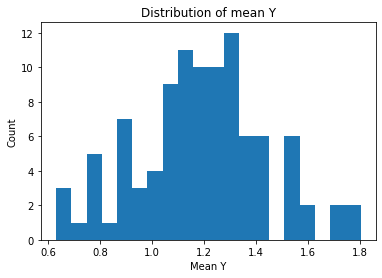

In [ ]:
# Generate data with Gaussian model
X, Y, w_true, w0_true = generate_dataset(model_type = 'gaussian', n_samples = 5000, n_features = 200, n_responses = 100, 
                                         fraction_observed_features = 0.8, clip_Y_value = 10000., plot_mean_responses = True)

print('Shape of observed X =', X.shape)
print('Shape of Y =', Y.shape)
print('Shape of true weights (observed part) =', w_true.shape)
print('Shape of true intercepts =', w0_true.shape)

## Train-validation-test split

As general practice in machine learning, when we fit the models, we want to split data into three parts: training, validation and test set. We use the training set to fit the model, validation set to select models (e.g. select models fitted with different regularization values), and test set for reporting the final model performance.

#### Randomly splitting data
The simplest way is to use `train_test_split` function from sklearn to randomly split data. Note that you can use the **stratify** argument to split data in a stratified way too (not done here). 

See documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html 

In [ ]:
## Split data into train and test set
test_size = 0.3

# Split data randomly with train_test_split function from sklearn
X_train, X_test_val, Y_train, Y_test_val = train_test_split(X, Y, test_size = test_size, random_state = 42)

# Further split test_val data into two: for validation and test
n_val = X_test_val.shape[0]//2
X_val = X_test_val[:n_val,:]
Y_val = Y_test_val[:n_val,:]
X_test = X_test_val[n_val:,:]
Y_test = Y_test_val[n_val:,:]


#### Split data according to a third-party provided group

Alternatively, Sometimes, we want to split data according to a third-party provided group to ensure that all samples of the same group are split into either train or test set. 

In practice, this is useful when fitting models to neural data. We usually would want to split the datapoints based on the trials, i.e. all timepoints within a trial should be split into the same set.

We can use `GroupShuffleSplit` function to do this.

See documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html

In [ ]:
## Alternatively, split data according to a third-party provided group with GroupShuffleSplit function from sklearn
n_samples = X.shape[0]
group_id = np.random.randint(low = 0, high = 50, size = n_samples)  # randomly assign datapoints to 50 groups
gss = GroupShuffleSplit(n_splits = 1, train_size = 0.85, random_state = 42)
fit_idx, test_idx = next(gss.split(X, Y, group_id))

X_fit = X[fit_idx,:]
Y_fit = Y[fit_idx,:]
X_test = X[test_idx,:]
Y_test = Y[test_idx,:]

# Split a small portion of training data into validation data
group_id_fit = group_id[fit_idx]
gss = GroupShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 42)
train_idx, val_idx = next(gss.split(X_fit, Y_fit, group_id_fit))

X_train = X_fit[train_idx,:]
Y_train = Y_fit[train_idx,:]
X_val = X_fit[val_idx,:]
Y_val = Y_fit[val_idx,:]

## Initialize GLM class

Before initializing a model, it's best practice to clear any previous "states" of tensorflow keras from prvious session by doing: 
```
tf.keras.backend.clear_session()
```

To initialize the GLM class, call ```glm.GLM()``` with proper input arguments.

There are 4 types of input arguments (there's a guide at the bottom):


*   **Model type**

   `activation`: {`'linear', 'exp', 'sigmoid', 'relu', 'softplus'`}, default = `'exp'`

  `loss_type`: {`'gaussian', 'poisson', 'binominal'`}, default = `'poisson'`


*   **Regularization**

    `regluarization`: {`'elastic_net', 'group_lasso'`}, default = `'elastic_net'`

     `lambda_series`: list or ndarray of a series of regularization strength (lambda), in descending order, default = `10.0 ** np.linspace(-1, -8, 30)`
    
     `l1_ratio`: L1 ratio for elastic_net regularization (`l1_ratio = 1.` is Lasso, `l1_ratio = 0.` is ridge), default = 0.
     
      `smooth_strength`: (advanced) strength for smoothness penalty, default = 0.

*   **Optimizer**

    `optimizer`: {`'adam', 'sgdm'`}, default = `'adam'`

    `learning_rate`: learning rate for optimizer, default = 1e-3

    `momentum`: momentum for sgdm optimizer, default = 0.5

*   **Convergence**

    `min_iter_per_lambda`: minimal iterations for each lambda, default = 100

    `max_iter_per_lambda`: maximal iterations for each lambda, default = 10000

    `num_iter_check`: number of iterations for checking convergence (delta loss is averaged over this number), default = 100

    `convergence_tol`: convergence criterion, complete fitting when absolute average delta loss over past num_iter_check iterations is smaller than convergence_tol*average null deviance of the data, default = 1e-6


**Guide**

1.   Make sure to change to `activation` and `loss_type` for your model type. Commonly used combinations of activation and loss: Gaussian: `'linear'` + `'gaussian'`; Poisson: `'exp'` + `'poisson'`; Logistic: `'sigmoid'` + `'binominal'`.
2.   Select your `regularization` and put in a series of regularization values in `lambda_series`. If you choose `regularization = 'elastic_net'`, please specify `l1_ratio`. `l1_ratio = 0` is L2 or ridge regression, `l1_ratio = 1` is L1 or Lasso regression, and anything in between uses a mixture of L1 and L2. 

  *Advnaced*: If your features in design matrix X can be categorized into separate groups (e.g. all derived features that come from basis expansion of one main feature), you may apply two other advnaced types of regularization: group lass regularization (by setting `regularization = 'group_lasso'`) and smoothness penalty (by setting `smooth_strength` to a value great than 0). You are required to arrange the design matrix X into blocks of features and provide the group size information at fitting time (see documentation for `fit` method in the next section).

*   *Group Lasso regularization*: Encourage between-group sparsity and within-group richness by performing L1 regularization on weights between groups and L2 regularization within groups. See Yuan, M., and Lin, Y. (2006). Model selection and estimation in regression with grouped variables. J. Royal Statistical Soc. B 68, 49–67.
*   *Smoothness penalty*: Encourage smoothness for weights within groups (useful for basis expanded features to ensure a smooth "tuning curve"). See Peron, S.P., Freeman, J., Iyer, V., Guo, C., and Svoboda, K. (2015). A Cellular Resolution Map of Barrel Cortex Activity during Tactile Behavior. Neuron 86, 783–799.  


3. Choose you `optimizer` but 'adam' is recommended. You may need to adjust your `learning_rate` when you inpect your loss curve during fitting. 
4. You may start with default values for convergence-related arguments, but adjust them according to your fitting time and loss curve.

In the follwoing example, I'm listing out all input arguments. But most of them have default values and you don't need to specify them.




In [ ]:
# Reset all keras states
tf.keras.backend.clear_session()

# Initialize GLM 
model = glm.GLM(activation = 'linear', loss_type = 'gaussian', 
                regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(3, -6, 10), l1_ratio = 0., smooth_strength = 0., 
                optimizer = 'adam', learning_rate = 1e-2, momentum = 0.5, 
                min_iter_per_lambda = 100, max_iter_per_lambda = 10**4, num_iter_check = 100, convergence_tol = 1e-6)


## Fit the model

We can fit the model by calling the method `fit`:

```
model.fit(X, Y, [initial_w0, initial_w, feature_group_size, verbose])
```

If you choose `'elastic_net'` for your regularization, you can simply call the method `fit` on training data to fit the model. You can supply the initial values for `w0` and `w` in `initial_w0` and `initial_w`. Setting `verbose = True` will print out the progress during model fitting, which is useful if you're debugging or searching for hyperparameters.

*Advanced:* If you set `regularization = 'group_lasso'` or `smooth_strength > 0.`, you need to sort your features in design matrix X (axis 1) into blocks of grouped features, and provide `feature_group_size` as input to the fit method. `feature_group_size` is a list containing the size of each group. For example, `feature_group_size = [10, 20, 15, 30, 1, 2]` means that there are 6 groups of your features. The first 10 features in your design matrix X belong to the first group, the next 20 features belong to the second group, and the next 15 features belong to the third group, ..., etc. 

**Input arguments:**

>`X`: design matrix, ndarray of shape (n_samples, n_features)

>`Y`: response matrix, ndarray of shape (n_samples, n_responses)

>`initial_w0`: optional, initial values of intercepts, ndarray of shape (n_responses,)

>`initial_w`: optional, initial values of weights, ndarray of shape (n_features, n_responses)

>`feature_group_size`: size of each group for `regularization = 'group_lasso'` or `smooth_strength > 0.,` list of positive integer of len = n_groups. The sum of all elements in the list must be equal to n_features, and the features in X (axis 1) have to be sorted in corresponding orders, as all fatures in group 0, followed by all fatures in group 1, all fatures in group 2, ..., etc.

>`verbose`: print loss during fitting or not, bool, default = True


In [ ]:
# Fit the model to training data
model.fit(X_train, Y_train, verbose = True)

Lambda 0 iter 100 loss: 12.65435123 diff: 0.01320179
Lambda 0 iter 200 loss: 12.47756004 diff: 0.00173925
Lambda 0 iter 300 loss: 12.46533966 diff: 0.00011972
Fitting with Lambda 0 iter 400 converged (loss diff = 0.00000555)
Lambda 1 iter 100 loss: 12.24433517 diff: 0.00199835
Fitting with Lambda 1 iter 200 converged (loss diff = 0.00000003)
Lambda 2 iter 100 loss: 10.51055813 diff: 0.01534120
Fitting with Lambda 2 iter 200 converged (loss diff = 0.00000025)
Lambda 3 iter 100 loss: 5.45979452 diff: 0.03683490
Fitting with Lambda 3 iter 200 converged (loss diff = 0.00000146)
Lambda 4 iter 100 loss: 2.81382179 diff: 0.00779003
Lambda 4 iter 200 loss: 2.80273533 diff: 0.00010988
Lambda 4 iter 300 loss: 2.80024719 diff: 0.00002464
Fitting with Lambda 4 iter 400 converged (loss diff = 0.00000494)
Lambda 5 iter 100 loss: 2.38589001 diff: 0.00025069
Lambda 5 iter 200 loss: 2.38283181 diff: 0.00003034
Fitting with Lambda 5 iter 300 converged (loss diff = 0.00000791)
Fitting with Lambda 6 iter 

### Examine loss curve

After fitting, we can take a look at the loss on training data during fitting by looking at `model.loss_trace`:

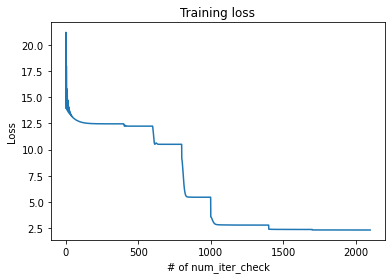

In [ ]:
# Plot loss trace
plt.plot(model.loss_trace)
plt.xlabel('# of num_iter_check')
plt.ylabel('Loss')
plt.title('Training loss');

The discontinuities correspond to where the fitting moved to next lambda value (with smaller regularization, thus the loss kept decreasing). 

You should adjust your `learning_rate` or convergence-related variables based on the loss curve.

The lambda value corresponding to the `loss_trace` can be found in `model.lambda_trace`.

In [ ]:
len(model.lambda_trace), len(model.loss_trace)

(2100, 2100)

## Model selection

After fitting the model, we'll perform model selection based on validation data. 

```
model.select_model(X_val, Y_val, [min_lambda, make_fig])
```

You can specify a minimal lambda value for the selection in `min_lambda`. If `make_plot = True`, it generates some summary plots for model selection.

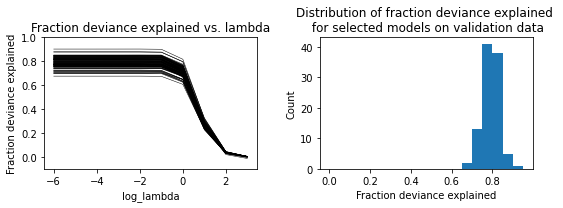

In [ ]:
# Perform model selection with validation data
model.select_model(X_val, Y_val, min_lambda = 1e-4, make_fig = True)

You can find the selected lambda values, lambda indices, and fraction deviance explained of selected models on validation data for each response by calling `selected_lambda`, `selected_lambda_ind`, and `selected_frac_dev_expl_val`.



In [ ]:
# Selected lambda values for each response
model.selected_lambda

array([0.001 , 0.01  , 0.01  , 0.01  , 0.01  , 0.01  , 0.01  , 0.01  ,
       0.0001, 0.0001, 0.1   , 0.01  , 0.01  , 0.01  , 0.01  , 0.01  ,
       0.01  , 0.01  , 0.01  , 0.01  , 0.1   , 0.01  , 0.001 , 0.01  ,
       0.01  , 0.01  , 0.0001, 0.01  , 0.01  , 0.1   , 0.001 , 0.001 ,
       0.01  , 0.0001, 0.01  , 0.1   , 0.01  , 0.01  , 0.1   , 0.0001,
       0.01  , 0.01  , 0.0001, 0.0001, 0.1   , 0.0001, 0.01  , 0.001 ,
       0.0001, 0.01  , 0.1   , 0.0001, 0.01  , 0.0001, 0.01  , 0.0001,
       0.01  , 0.01  , 0.01  , 0.1   , 0.01  , 0.01  , 0.1   , 0.01  ,
       0.1   , 0.01  , 0.01  , 0.01  , 0.01  , 0.0001, 0.01  , 0.01  ,
       0.0001, 0.01  , 0.1   , 0.01  , 0.0001, 0.01  , 0.01  , 0.01  ,
       0.1   , 0.1   , 0.01  , 0.01  , 0.01  , 0.0001, 0.0001, 0.01  ,
       0.1   , 0.1   , 0.1   , 0.01  , 0.01  , 0.1   , 0.0001, 0.0001,
       0.1   , 0.01  , 0.1   , 0.001 ])

In [ ]:
# Selected lambda indices for each response
model.selected_lambda_ind

array([5, 4, 5, 6, 7, 7, 5, 7, 4, 5, 7, 7, 5, 5, 4, 5, 7, 5, 4, 7, 7, 7,
       5, 5, 5, 5, 5, 4, 7, 5, 6, 4, 5, 5, 5, 5, 6, 5, 5, 6, 4, 7, 5, 5,
       5, 5, 5, 7, 5, 5, 5, 5, 4, 5, 7, 5, 5, 5, 5, 6, 7, 5, 5, 5, 7, 7,
       5, 7, 5, 5, 5, 5, 7, 5, 5, 4, 4, 5, 5, 5, 7, 6, 5, 5, 4, 5, 7, 5,
       5, 5, 5, 4, 7, 5, 6, 7, 7, 5, 4, 6])

In [ ]:
# Examine fraction deviance explained on validation data for selected models for each response
model.selected_frac_dev_expl_val

array([0.77757229, 0.82409458, 0.7075973 , 0.82509608, 0.80300156,
       0.75558045, 0.79373139, 0.84266053, 0.75859377, 0.79915439,
       0.83741991, 0.82212173, 0.67318462, 0.86299122, 0.84033135,
       0.76027517, 0.78225656, 0.79057458, 0.78760267, 0.7758593 ,
       0.77681526, 0.82054742, 0.82200538, 0.7741135 , 0.8267582 ,
       0.84424269, 0.83726441, 0.75837056, 0.78939398, 0.83234043,
       0.84788782, 0.7100668 , 0.78131051, 0.81095352, 0.78456127,
       0.79795666, 0.66845614, 0.79530926, 0.76487074, 0.77444525,
       0.83076935, 0.81177443, 0.84058316, 0.78401201, 0.76705001,
       0.81462358, 0.77612836, 0.79434941, 0.75892775, 0.75162839,
       0.8304799 , 0.7591448 , 0.80587664, 0.76945436, 0.78324014,
       0.86084438, 0.78040711, 0.83808192, 0.72811877, 0.87801135,
       0.79867459, 0.70933746, 0.746398  , 0.77692429, 0.77594174,
       0.77431144, 0.79865995, 0.71687182, 0.79514521, 0.8092349 ,
       0.79473888, 0.81449133, 0.73710115, 0.62366972, 0.81924

## Model evaluation

We can evaluate model performance (in fraction deviance explained) on test data.

```
frac_dev_expl, dev_model, dev_null, dev_expl = model.evaluate(X, Y, [make_fig])
```

This returns fraction deviance explained, model deviance, null deviance and deviance explained for each response. With `make_fig = True` it also generates summary plots for the evaluation.




Fraction deviance explained: mean = 0.7892, median = 0.7900


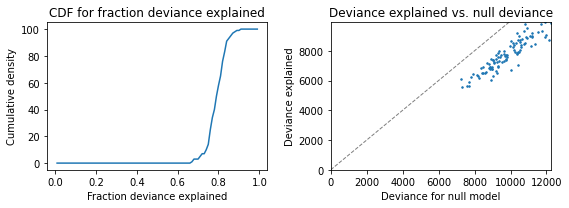

In [ ]:
# Evaluate model performance on test data
frac_dev_expl, dev_model, dev_null, dev_expl = model.evaluate(X_test, Y_test, make_fig = True)

Note that you can perform evalutaion on training data and validation data too.

In [ ]:
# Evalute model performance on train and validation data
frac_dev_expl_train, _, _, _ = model.evaluate(X_train, Y_train, make_fig = False)
frac_dev_expl_validation, _, _, _ = model.evaluate(X_val, Y_val, make_fig = False)

Fraction deviance explained: mean = 0.8122, median = 0.8133
Fraction deviance explained: mean = 0.7913, median = 0.7934


## Get model weights

You can get weight and bias from `model.selected_w` and `model_selected_w0`.

In [ ]:
# Get model weights
selected_w = model.selected_w.copy()
selected_w.shape, selected_w

((160, 100), array([[-0.04759163,  0.37953413, -0.37950045, ...,  0.05673795,
          0.1254002 ,  0.49766892],
        [-0.02495763,  0.69582045, -0.22715174, ...,  0.11657143,
          0.09380929, -0.26700422],
        [-0.2766307 ,  0.20976551, -0.62963897, ..., -0.09738355,
         -0.3003428 ,  0.27631095],
        ...,
        [ 0.08828266,  0.00820341, -0.10916034, ..., -0.17242683,
         -0.24318872, -0.12345928],
        [-0.25330862,  0.02808875, -0.01772682, ...,  0.04906034,
         -0.1351453 , -0.13264546],
        [ 0.37404257, -0.25908157, -0.0998913 , ...,  0.01835965,
          0.10183357,  0.16537437]], dtype=float32))

In [ ]:
# Get model intercepts
selected_w0 = model.selected_w0.copy()
selected_w0.shape, selected_w0

((100,), array([0.8319701 , 1.4008809 , 1.3292329 , 0.89655006, 0.7898147 ,
        1.208774  , 1.0789173 , 0.6434824 , 1.2790692 , 1.0131223 ,
        1.2647865 , 1.1101913 , 0.9559468 , 1.7200493 , 1.2643068 ,
        1.3130934 , 1.5401535 , 0.7124728 , 1.0480683 , 1.1993645 ,
        1.4025259 , 1.5302659 , 1.195091  , 1.0946062 , 1.253628  ,
        1.2030557 , 1.688245  , 1.0359415 , 1.2539507 , 1.1387877 ,
        0.9643258 , 1.4001423 , 1.1006911 , 1.3832089 , 1.062981  ,
        1.4441684 , 1.1334064 , 0.7961888 , 1.1316154 , 1.2388648 ,
        1.2825624 , 1.5269638 , 1.5450978 , 1.5300833 , 1.0737662 ,
        0.8815406 , 0.744085  , 0.6581007 , 1.382162  , 1.4355601 ,
        1.3092933 , 1.2239264 , 1.1657126 , 1.0778518 , 0.87586975,
        0.92807406, 1.2021947 , 1.3411936 , 1.1547399 , 1.20077   ,
        1.2935042 , 1.3708827 , 1.5999383 , 1.2193024 , 1.8116918 ,
        0.89183474, 1.1740437 , 1.2083726 , 1.7493092 , 1.077058  ,
        1.3181561 , 1.5412632 , 0.895316

We can compare the model weights / intercepts to ground truth.

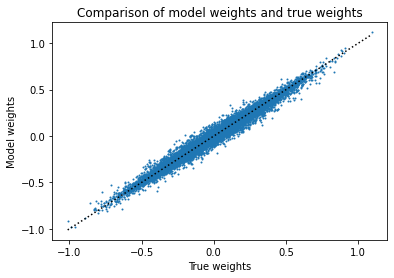

In [ ]:
# Compare model weights and true weights
plt.scatter(w_true.flatten(), selected_w.flatten(), s = 1)
plt.plot([w_true.min(),w_true.max()],
         [w_true.min(),w_true.max()],'k:')
plt.xlabel('True weights')
plt.ylabel('Model weights')
plt.title('Comparison of model weights and true weights');

You may see the "shrinkage effect" of the weights due to regularization (dependent on how you set up the dataset and hyperparameters).

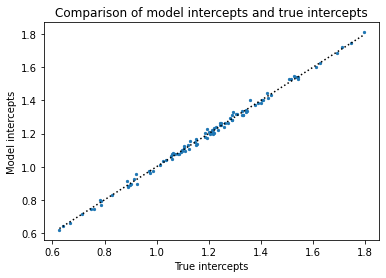

In [ ]:
# Compare model intercepts and true intercepts
plt.scatter(w0_true, selected_w0, s = 5)
plt.plot([w0_true.min(),w0_true.max()],
         [w0_true.min(),w0_true.max()],'k:')
plt.xlabel('True intercepts')
plt.ylabel('Model intercepts')
plt.title('Comparison of model intercepts and true intercepts');

## Make prediction

To make prediction with the selected model, use `predict` method.


```
model.predict(X)
```





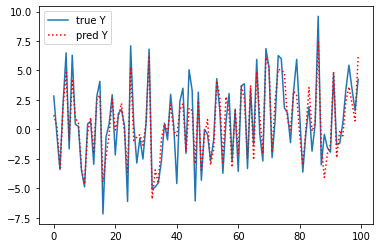

In [ ]:
# Make prediction on X_test and compare to Y_test
Y_pred = model.predict(X_test)

n_t = 100
response_idx = 0
plt.plot(Y_test[:n_t,response_idx], label = 'true Y')
plt.plot(Y_pred[:n_t,response_idx],'r:', label = 'pred Y')
plt.legend();


Alternatively, you can call an external function for making prediction by supplying X, w, w0 and activation directly.


```
Y_pred = glm.make_prediction(X, w, w0, activation)
```

Here is the definition of the function:


```
def make_prediction(X, w, w0, activation = 'exp'):
    '''
    Make GLM prediction
    Input parameters::
    X: design matrix, ndarray of shape (n_samples, n_features)
    w: weight matrix, ndarray of shape (n_features, n_responses)
    w0: intercept matrix, ndarray of shape (1, n_responses)
    activation: {'linear', 'exp', 'sigmoid', 'relu', 'softplus'}, default = 'exp'
    
    Returns::
    prediction: model prediction, ndarray of shape (n_samples, n_responses)
    '''

```



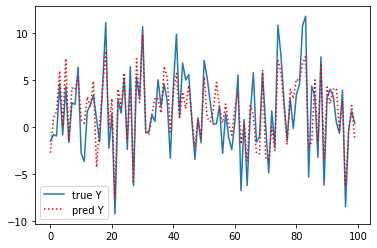

In [ ]:
Y_pred = glm.make_prediction(X_test, selected_w, selected_w0, activation = 'linear')

n_t = 100
response_idx = 0
plt.plot(Y_test[:n_t,response_idx], label = 'true Y')
plt.plot(Y_pred[:n_t,response_idx],'r:', label = 'pred Y')
plt.legend();

# Fit GLM with cross validation

A more robust way for model selection is to use cross-validation. In k-fold cross validation, We split data into k subsets (typically k = 5 or 10), train the model on all datapoints in the k-1 subsets and validate on the remaining datapoints. And then we select models based on their average validation performanace across all folds. 

A detailed explanation can be found here: https://scikit-learn.org/stable/modules/cross_validation.html


### Prepare dataset

First we prepare the dataset.

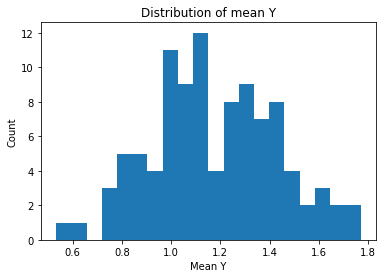

In [ ]:
# Generate data with Gaussian model
X, Y, w_true, w0_true = generate_dataset(model_type = 'gaussian', n_samples = 5000, n_features = 200, n_responses = 100, 
                                         fraction_observed_features = 0.8, clip_Y_value = 10000., plot_mean_responses = True)

## Train-test-split

Here we only have to split the data into training & test set, and we'll perform cross validation on the training data. Test data is used for reporting final model performance. Here, we're spliting the data with third-party provided group information.

In [ ]:
# Split data according to a third-party provided group
n_samples = X.shape[0]
group_id = np.random.randint(low = 0, high = 50, size = n_samples)  # randomly assign datapoints to 50 groups
gss = GroupShuffleSplit(n_splits = 1, train_size = 0.85, random_state = 42)
train_idx, test_idx = next(gss.split(X, Y, group_id))

X_train = X[train_idx,:]
Y_train = Y[train_idx,:]
X_test = X[test_idx,:]
Y_test = Y[test_idx,:]
group_id_train = group_id[train_idx]

## Initialize GLM with cross validation

To initialize GLM with cross validation, call `GLM_CV()` with proper input arguments.
```
model_cv = glm.GLM_CV()
```

`GLM_CV` is a class inherited from `GLM`. It has some additional input parameters:

>`n_folds`: number of CV folds, default = 5

>`auto_split`: perform CV split automatically or not, bool, default = True

>`split_by_group`: perform CV split according to a third-party provided group when auto_split = True, default = True

>`split_random_state`: optional, numpy random state for CV splitting

All other input arguments are identical to those in `GLM`. 

If you set `auto_split = True`, the model with perform CV splits for you; if `auto_split = False`, you need to provide splitting indices in a specific format when calling the `fit` method. 

When `auto_split = True`, if you set `split_by_group = True`, you need to provide grouping information when calling the `fit` method; if `split_by_group = False`, the model will split the data randomly.

In [ ]:
# Reset keras states
tf.keras.backend.clear_session()

# Initialize GLM_CV (here I'm listing out all input arguments, but many of them can be left with default values)
model_cv = glm.GLM_CV(n_folds = 5, auto_split = True, split_by_group = True, split_random_state = 42,
                      activation = 'linear', loss_type = 'gaussian', 
                      regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(3, -6, 10), 
                      l1_ratio = 0., smooth_strength = 0., 
                      optimizer = 'adam', learning_rate = 1e-2, momentum = 0.5, 
                      min_iter_per_lambda = 100, max_iter_per_lambda = 10**4, 
                      num_iter_check = 100, convergence_tol = 1e-6)


## Fit the model

Call the `fit` method to fit the model.


```
model_cv.fit(X, Y, [train_idx, val_idx, group_idx, initial_w0, initial_w, 
             feature_group_size, verbose])
```

If we set `auto_split = True` and `split_by_group = False`, we can call 

>```model_cv.fit(X_train, Y_train)```

If we set `auto_split = True` and `split_by_group = True`, we need to provide the group indices:

>```model_cv.fit(X_train, Y_train, group_idx = group_idx)```

If we set `auto_split = False`, we need to provide `train_idx` and `val_idx`:

>```model_cv.fit(X_train, Y_train, train_idx = train_idx, val_idx = val_idx)```


`train_idx` is a dictionary containing indices (**indices in number**, not bool or 1/0) for training data for each fold, with key:value pairs arranged as `{n_fold: ndarray containing training indices of that fold for n_fold in range(n_folds)}` 

`val_idx` is a dictionary containing indices (**indices in number**, not bool or 1/0) for training data for each fold, with key:value pairs arranged as `{n_fold: ndarray containing validation indices of that fold for n_fold in range(n_folds)}`

If you want to split the data on you own, check out `KFold` and `GroupKFold` from sklearn for generating CV splits with random splitting and splitting based on a third-party group, respectively. See sklearn documentation here:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html

In [ ]:
# Fit the model with group_idx provided for CV split
model_cv.fit(X_train, Y_train, group_idx = group_id_train, verbose = True)

n_fold = 0
Lambda 0 iter 100 loss: 13.04640102 diff: 0.01294598
Lambda 0 iter 200 loss: 12.87685108 diff: 0.00166775
Lambda 0 iter 300 loss: 12.86535358 diff: 0.00011260
Fitting with Lambda 0 iter 400 converged (loss diff = 0.00000483)
Lambda 1 iter 100 loss: 12.63604259 diff: 0.00207422
Fitting with Lambda 1 iter 200 converged (loss diff = 0.00000002)
Lambda 2 iter 100 loss: 10.84190369 diff: 0.01586916
Fitting with Lambda 2 iter 200 converged (loss diff = 0.00000027)
Lambda 3 iter 100 loss: 5.65817595 diff: 0.03772188
Fitting with Lambda 3 iter 200 converged (loss diff = 0.00000151)
Lambda 4 iter 100 loss: 2.95746660 diff: 0.00792953
Lambda 4 iter 200 loss: 2.94563484 diff: 0.00011726
Lambda 4 iter 300 loss: 2.94299722 diff: 0.00002612
Fitting with Lambda 4 iter 400 converged (loss diff = 0.00000519)
Lambda 5 iter 100 loss: 2.51947284 diff: 0.00025892
Lambda 5 iter 200 loss: 2.51623297 diff: 0.00003215
Fitting with Lambda 5 iter 300 converged (loss diff = 0.00000830)
Fitting with Lam

## Model selection

Call `select_model` method to perform model selection.



```
model_cv.select_model([se_fraction, min_lambda, make_fig])
```

Note that we don't need to provide validation data since the model selection is based on model performance on held-out data for all CV folds.

Normally we would like to select models with the largest regularization (the most parsimonious mode) whose performance is not substantially worse than the model with minimal CV errors. One way to do so is to select the model with largest regularization that it's mean model performance across all CV folds is within one standard error range of the mean model performance across all CV folds for the one with best model performance, which is called "one-standard-error rule" (1SE rule).

`se_fraction` controls the tolerance of choosing models with smallest deviance vs. larger regularization; `se_fraction = 0.` means selecting models with the smallest model deviance (i.e. highest explained deviance); `se_fraction = 1.` means selecting models using the 1SE rule; or set se_fraction to arbitrary positive number to control the tolerance; default = 1.


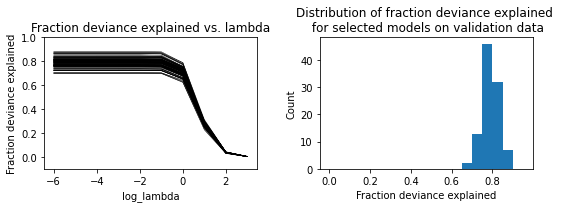

In [ ]:
# Select the model using 1SE rule and given minimal lambda
model_cv.select_model(se_fraction = 1, min_lambda = 1e-5, make_fig = True)

You can find the selected lambda values, lambda indices, and fraction deviance explained of selected models on CV held-out data for each response by calling `selected_lambda`, `selected_lambda_ind`, and `selected_frac_dev_expl_cv`.

In [ ]:
# Examine selected lambda values for all responses
model_cv.selected_lambda

array([0.1 , 0.1 , 0.1 , 0.01, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.01, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 ])

We can see that, with the 1SE rule, the models tend to select larger regularization at 0.1

In [ ]:
# Examine selected lambda indices for all responses
model_cv.selected_lambda_ind

array([4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
# Examine fraction deviance explained on CV held-out data of the selected models for all responses
model_cv.selected_frac_dev_expl_cv

array([0.69463392, 0.76191294, 0.75879118, 0.87299969, 0.79542541,
       0.79110681, 0.7823613 , 0.79172488, 0.86742278, 0.7486342 ,
       0.82711751, 0.78555199, 0.76782528, 0.76730072, 0.83512627,
       0.76015473, 0.82922883, 0.74474245, 0.86432239, 0.75467565,
       0.7894561 , 0.84103368, 0.8242901 , 0.78884961, 0.78618539,
       0.82859822, 0.79809357, 0.73125564, 0.74023599, 0.75194444,
       0.79077612, 0.78204613, 0.83606133, 0.76172979, 0.82691511,
       0.7554466 , 0.75171673, 0.79430517, 0.78587966, 0.78503586,
       0.77227108, 0.82286254, 0.73918896, 0.75510553, 0.77728154,
       0.81880402, 0.84667664, 0.81321986, 0.75371735, 0.72710138,
       0.79672299, 0.84338843, 0.76757148, 0.79652649, 0.7228068 ,
       0.82272375, 0.78358647, 0.73628389, 0.78628344, 0.78402254,
       0.84086211, 0.8322722 , 0.79783314, 0.83492364, 0.70302696,
       0.85185181, 0.69462933, 0.76748039, 0.72907779, 0.78225637,
       0.80989082, 0.86432606, 0.80726794, 0.82153386, 0.77047

## Evaluation, prediction, and model weights

We can use the same methods as in class `GLM` to evaluate model, make prediction, and obtain model weights.




Fraction deviance explained: mean = 0.7868, median = 0.7839


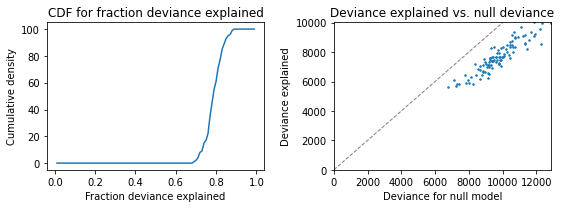

In [ ]:
# Evaluate model performance on test data
frac_dev_expl, dev_model, dev_null, dev_expl = model_cv.evaluate(X_test, Y_test, make_fig = True)

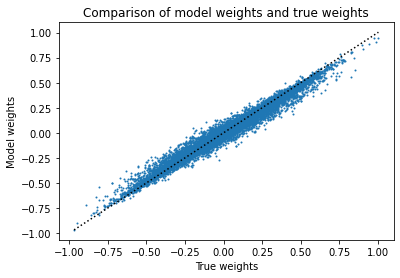

In [ ]:
# Compare model weights and true weights
selected_w_cv = model_cv.selected_w.copy()
plt.scatter(w_true.flatten(), selected_w_cv.flatten(), s = 1)
plt.plot([w_true.min(),w_true.max()],
         [w_true.min(),w_true.max()],'k:')
plt.xlabel('True weights')
plt.ylabel('Model weights')
plt.title('Comparison of model weights and true weights');

You can see a little bit of "shrinkage effect" of the model weights since we are selecting models with larger regularization with the 1SE rule.

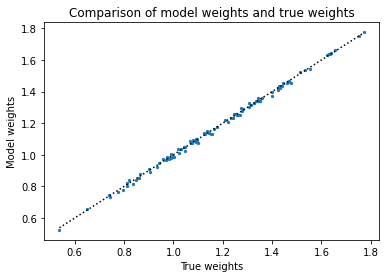

In [ ]:
# Compare model intercepts and true intercepts
selected_w0_cv = model_cv.selected_w0.copy()
plt.scatter(w0_true.flatten(), selected_w0_cv.flatten(), s = 5)
plt.plot([w0_true.min(),w0_true.max()],
         [w0_true.min(),w0_true.max()],'k:')
plt.xlabel('True weights')
plt.ylabel('Model weights')
plt.title('Comparison of model weights and true weights');

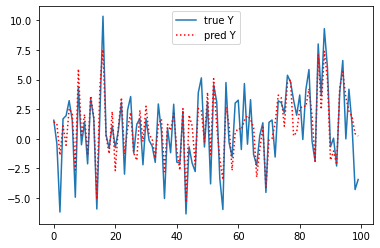

In [ ]:
# Make prediction on X_test and compare to Y_test
Y_pred = model_cv.predict(X_test)

n_t = 100
response_idx = 0
plt.plot(Y_test[:n_t,response_idx], label = 'true Y')
plt.plot(Y_pred[:n_t,response_idx],'r:', label = 'pred Y')
plt.legend();